In [1]:
%config InlineBackend.figure_format = 'svg'
import ipywidgets as widgets
from IPython.display import display
import eq_functions as eq
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime
from pyswarm import pso
from scipy import optimize

np.random.seed(1756)
random.seed(1756)

Notebook for fitting the 2D pressure diffusion model to induced seismicity datasets from http://wellbore.lbl.gov/egs/index.html

In [2]:
# Read in data from text file.
# Store earthquakes as a list of 'Event' instances.
# The metrics dataframe contains location-specific data such as optimiser parameter bounds,
# latitude/longitude of injection well.
rr = [42.088309, -113.387377]
nwb = [43.726077, -121.309651]
brd = [39.791999, -119.013119]
rrt0 = datetime(2010, 10, 2 , hour=8, minute=13, second=26) # first event times
nwbt0 = datetime(2012, 10, 29, hour=8, minute=2, second=21)
brdt0 = datetime(2010, 11, 13 , hour=8, minute=37, second=24)
metrics = pd.DataFrame({'lat0':[nwb[0], rr[0], brd[0]],
                        'long0':[nwb[1], rr[1], brd[1]],
                        't0':[nwbt0, rrt0, brdt0],
                        'ru':[10**2.63, 10**3.2, 1*1e3],
                        'rl':[3*1e1, 150, 1e1],
                        'T_inj':[1.901e+6, 1.616e+7, 1.642e+6],
                        'T_adjust':[432000, 1.382e+6, 0],
                        'range':[slice(150,402),slice(48,82), slice(0,-1)],
                        'q_lwr':[10,16.8,10],
                        'q_upr':[1000,883.2,1000],
                        'rc_lwr':[40,320,50],
                        'rc_upr':[100,450,300]},
    index =  ['newberry.txt','raft_river.txt','bradys.txt'])

def extract_events(fname):
    '''
    extract data from text file to store events in a list
    '''
    f = open(fname, 'r')
    flines = f.readlines()
    f.close()

    r = 6371e3 # earth radius in m
    lat0, long0, t0 =  metrics.loc[fname].lat0, metrics.loc[fname].long0, metrics.loc[fname].t0 #43.725820, -121.310371 OG # newberry # 42.088047, -113.385184# raft river #  
    x0 = eq.gnom_x(lat0,long0,lat0,long0)
    y0 = eq.gnom_y(lat0,long0,lat0,long0)

    # store events in list
    # latitudes and longitudes are projected to a plane using a gnomonic projection
    # distances between points and the origin (mean lat,lon) are determined by great circle distances between origin and the points
    events_all = [eq.Event(float(event.split()[10]), \
                           (datetime(int(event.split()[0]),int(event.split()[2]),int(event.split()[3]),hour=int(event.split()[4]),minute=int(event.split()[5]),second=int(float(event.split()[6])))-t0).total_seconds(), \
                           r*eq.gnom_x(float(event.split()[7]),float(event.split()[8]),lat0,long0, deg = True),\
                           r*eq.gnom_y(float(event.split()[7]),float(event.split()[8]),lat0,long0, deg = True),\
                           '-', eq.gcdist(r,float(event.split()[7]),lat0,float(event.split()[8]),long0, deg = True), 0) for event in flines]# if event.split()[0] in year]
    return events_all, flines, fname
    
loc_options = widgets.Select(options = ['newberry.txt','raft_river.txt','bradys.txt'], value = 'newberry.txt', description='Location select: ')

events_all = widgets.interactive(extract_events, fname=loc_options)
display(events_all)

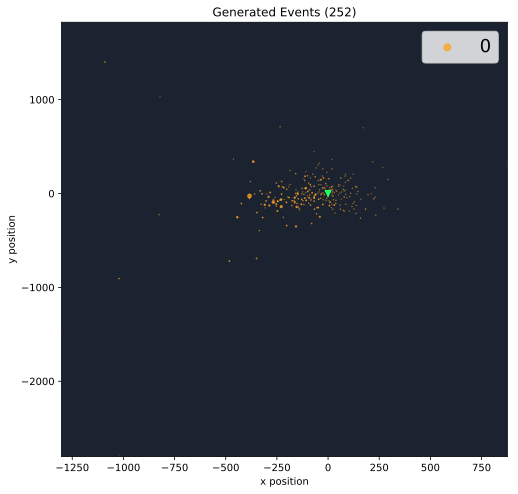

In [3]:
# put events into a catalog and plot earthquake positions
events = events_all.result[0]
flines = events_all.result[1]
fname = events_all.result[2]
catalog0 = pd.DataFrame({'Magnitude': [event.magnitude for event in events],
                                   'Time':[event.time for event in events],
                                   'x':[event.x for event in events],
                                   'y':[event.y for event in events],
                                   'Generation':[0] * len(events),
                                   'Distance_from_origin': [event.distance_from_origin for event in events],
                                   'Date':[datetime(int(event.split()[0]),int(event.split()[2]),int(event.split()[3]),hour=int(event.split()[4]),minute=int(event.split()[5]),second=int(float(event.split()[6]))) for event in flines]})
cols = ['Magnitude','Generation','x','y','Time','Distance_from_origin','Date']
catalog0 = catalog0.reindex(columns = cols)
catalog0 = catalog0[metrics.loc[fname].range] # get events from time period of interest
catalog0.Time = catalog0.Time - catalog0.Time.min() + metrics.loc[fname].T_adjust # shift time so that first event occurs however long after injection began

eq.plot_catalog(catalog0, 1, np.array([0,0]), color = 'Generation')

In [4]:
# choose nsplits on which to fit model
# e.g nsplits = 3 will fit to each of 33.3..%, 66.6..% and 100% of the time period
# also intialise arrays to store distance, densities, and time for each split
def get_nsplit(nsplit):
    return nsplit
N = len(catalog0)
k = int(np.ceil(N**0.5))
splits = widgets.IntSlider(min = 1, max = 4, value = 3, step = 1, description = 'nsplits')
nsplit = widgets.interactive(get_nsplit, nsplit = splits)
display(nsplit)
r_all = []
dens_all = []
t = []

In [5]:
amount = np.ceil(np.linspace(N/nsplit.result, N, nsplit.result))
T = metrics.loc[fname].T_inj
for i, n in enumerate(amount):
    catalog = catalog0.copy() # prevent master catalog being modified
    catalog = catalog[:int(n)] 
    assert len(catalog) > k, "Number of nearest neighbours exceed catalog size"
    r, densities = eq.plot_ED(catalog, k = k,  plot = False) # get distance, density
    
    # estimate densities prior to filtering by distance, so that they are not affected by absent events
    mask_filter_farevents =  r < metrics.loc[fname].ru # mask for far field events
    r = r[mask_filter_farevents]
    densities = densities[mask_filter_farevents]
    r_all.append(r)
    dens_all.append(densities)

    rmax = r.max()
    rmin = r.min()
    n_edges = 32
    t_now = catalog.Time.max()
    t.append(t_now)

In [6]:
# particle swarm optimisation

# pso constraints - some bounds have been made location dependent
lb = [1e-16, 1e-14, 0.8e-6, metrics.loc[fname].q_lwr, metrics.loc[fname].rc_lwr, 1e-10]+[1e-5]*nsplit.result
ub = [0.1, 1e-6, 1.3e-6, metrics.loc[fname].q_upr, metrics.loc[fname].rc_upr, 2]+[1e1]*nsplit.result
# alpha, k, nu, q, rc, pc, C
bounds = [(low, high) for low, high in zip(lb,ub)] # basinhop bounds
const = (r_all, dens_all, False, lb, ub, T, t)

# do particle swarm opti.
theta0, obj = pso(eq.robj_diff, lb, ub, args = const, maxiter = 500, swarmsize = 500, phip = 0.75, minfunc = 1e-12, minstep = 1e-12, phig = 0.8)


Stopping search: Swarm best objective change less than 1e-12


In [7]:
# plot results

alpha, k, nu, q, rc, pc = theta0[:6]
C = theta0[6:]
colors = ['r','b','y','k']
def plot_fit(loglog=False):
    f, ax = plt.subplots(1, figsize = (7,4))
    rplot = np.linspace((rmin),(rmax),500)
    rplot_all = [rplot, rplot, np.linspace(rmin,rmax,500)]
    for i, n in enumerate(amount):
        ax.plot(r_all[i], dens_all[i], 'o', alpha = 0.3, color = colors[i])
        dens_model = eq.p2D_transient(rplot_all[i], t[i], C[i], pc, alpha, T, k, nu, q, rc)
        dens_model[dens_model<=0] = np.nan
        ax.plot(rplot_all[i], dens_model,'-',label='At {0:.1f} days'.format(t[i]/60/60/24), color = colors[i])
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_xlabel('distance from well (m)')
    ax.set_ylabel(r'event density $(/m^2)$')
    plt.title(fname.split(sep=".")[0])
    plt.legend(loc = 'upper right')
    plt.show()

loglog = widgets.Checkbox(value = False, description = 'Plot log-log')
fits = widgets.interactive(plot_fit, loglog = loglog)
display(fits)